# Exploratory Data Analysis
* https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies/notebook
* https://www.kaggle.com/jerrythomas/exploratory-analysis
* https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering

In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from imageio import imread
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict

# Some constants 
TRAIN_FOLDER = './data/train/'
TEST_FOLDER = './data/test/'
TEST_INPUT_FOLDER = './data/test/input/'
INPUT_FOLDER = TRAIN_FOLDER + 'input/'
LABELS_FOLDER = TRAIN_FOLDER + 'labels/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

For now, let's go ahead and convert the images to gray scale in order to simplify things.

In [3]:
from skimage.color import rgb2gray

def load_input_image(patient, inp_folder=INPUT_FOLDER):
    return rgb2gray(imread(inp_folder + patient + '/images/' + os.listdir(inp_folder + patient + '/images/')[0]))
    
def load_input_masks(patient):
    masks = os.listdir(INPUT_FOLDER + patient + '/masks/')
    return [imread(INPUT_FOLDER + patient + '/masks/' + mask) for mask in masks]

def get_num_nuclei(patient):
    return len(os.listdir(INPUT_FOLDER + patient + '/masks/'))

## Preview Images
Let's start by looking at some of the training images and a few of their respective masks. With all the masks composed into one image, we can clearly see where overlapping nuclei would be a problem for naive image segmentation algorithms. 

218
468
193


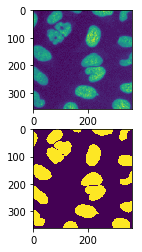

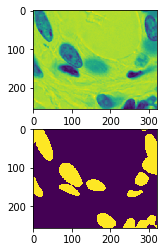

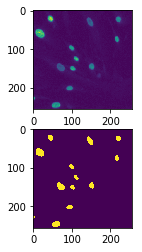

In [4]:
def get_composed_masks_img(patient):
    masks = load_input_masks(patient)
    composed_mask = masks[0]
    for mask in masks:
        composed_mask = np.maximum(composed_mask, mask)
    return composed_mask

def show_image_and_masks(patient):
    masks = load_input_masks(patient)
    fig = plt.figure()
    plt.title("Patient: {}".format(patient))
    plt.subplot(211)
    plt.imshow(load_input_image(patient))
    masks = load_input_masks(patient)
    composed_mask = get_composed_masks_img(patient)
    plt.subplot(212)
    plt.imshow(composed_mask)
    
    
for i in range(3):
    idx = random.choice(range(len(patients)))
    print(idx)
    masks = load_input_masks(patients[idx])
    show_image_and_masks(patients[idx])

## Data Statistics
Let's look at some statistics of the dataset

       num_nuclei
count  670.000000
mean    43.971642
std     47.962530
min      1.000000
25%     15.250000
50%     27.000000
75%     54.000000
max    375.000000


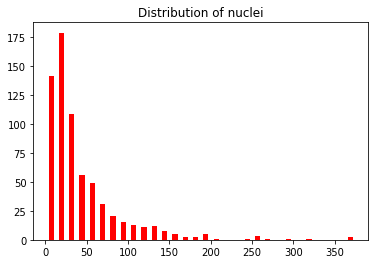

In [18]:
# count number of masks for each dataset
num_nuclei = [get_num_nuclei(patient) for patient in patients]
df = pd.DataFrame({'patient': patients, 'num_nuclei': num_nuclei})
df = df.set_index('patient')
print (df.describe())

plt.hist(num_nuclei, 30, rwidth=0.5, color='red')
plt.title("Distribution of nuclei")
plt.show()

In [ ]:
# plot distribution of image sizes
heights = []
widths = []
sizetocount = defaultdict(int)
for patient in patients:
    size = load_input_image(patient).shape
    sizetocount[size] += 1
    

ind = np.arange(len(sizetocount))  # the x locations for the groups
width = 0.7       # the width of the bars
plt.bar(ind, sizetocount.values(), width, color='r')
plt.xticks(ind, tuple(sizetocount.keys()), rotation='vertical')
plt.title("Distribution of image sizes")
plt.show()

From the statistics described, we see that every image has at least one nuclei in it, and we can get up to a lot of nuclei (probably meaning that there are a lot of overlaps). In addition, we see that the standard deviation is pretty high, so we have a high distribution of different nuclei numbers per image. With a mean of 44 and a standard deviation of ~48, we can see that there is high variance above ~50 nuclei.

###### plt.hist(num_nuclei, bins=75)

Plotting a histogram of the distribution, we can see that most of the examples are between 0 and 50 nuclei, but with a max of 375 nuclei in one image. Also, we see that none of the examples have no nuclei, so every image will have something to segment.

In [ ]:
# for patient in patients[:3]:
#     img = load_input_image(patient)
#     heights, xs = np.histogram(img)
#     plt.hist(img, bins=xs)

### Future Modeling
Some initial thoughts about future methods to model this problem and predict the appropriate masks involve:
* Gaussian Filter and Naive Bayes (for baseline)
* Gaussian Filter and Naive Bayes with some image preprocessing for separating overlapping nuclei (perhaps training a CNN on that specific task)
* CNN
* CNN with CNN image preprocessing for separating overlapping nuclei


Let's go ahead and see what applying a Gaussian filter on the first patient would look like. We use the **Otsu** method to segment the nuclei from the image background.

In [22]:
from skimage.filters import gaussian
try:
    from skimage import filters
except ImportError:
    from skimage import filter as filters
def otsu_method(img):
    val = filters.threshold_otsu(img)
    segmented_img = img > val
#     gauss_img = gaussian(segmented_img, sigma=.5)
    return segmented_img

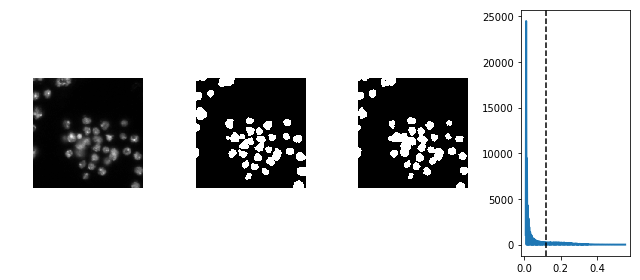

In [23]:
import matplotlib.pyplot as plt
try:
    from skimage import filters
except ImportError:
    from skimage import filter as filters
from skimage import exposure

curr_patient = patients[249]
img = load_input_image(curr_patient)
val = filters.threshold_otsu(img)
segmented_img = img > val

hist, bins_center = exposure.histogram(img)

plt.figure(figsize=(9, 4))
plt.subplot(141)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(142)
plt.imshow(get_composed_masks_img(curr_patient), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(143)
plt.imshow(img > val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(144)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()

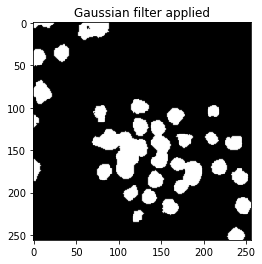

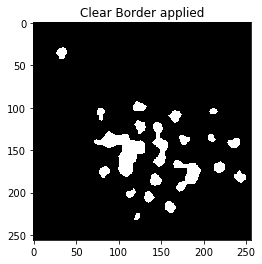

In [24]:
from skimage.segmentation import clear_border
from skimage.filters import gaussian

gauss_img = gaussian(segmented_img, sigma=.5)
plt.figure()
plt.title('Gaussian filter applied')
plt.imshow(gauss_img, cmap='gray')

clear_border_img = clear_border(gauss_img)
plt.figure()
plt.title('Clear Border applied')
plt.imshow(clear_border_img, cmap='gray')

We can see that this does a deecnt job of getting all the distinctly separated nuclei components, but it doesn't do very well on separating the overlapping nuclei. We will explore how we can fix that problem in our next progress report

In [25]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

# print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

In [26]:
def analyze_image(patient):
    img = load_input_image(patient, inp_folder=TEST_FOLDER)
    segmented_img = otsu_method(img)
    rle = rle_encoding(segmented_img)
    s = pd.Series({'ImageId': patient, 'EncodedPixels': rle})
    im_df = pd.DataFrame()
    im_df = im_df.append(s, ignore_index=True)
    return im_df

In [27]:
def analyze_list_of_images(patients):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for patient in patients:
        im_df = analyze_image(patient)
        all_df = all_df.append(im_df, ignore_index=True)
    return all_df

In [28]:
test_patients = os.listdir(TEST_FOLDER)

In [29]:
df = analyze_list_of_images(test_patients)
df.to_csv('submission.csv', index=None)